# My Content - Recommender System

## Téléchargement et Prétraitement des Données

Dans ce notebook, nous allons télécharger les fichiers de données et les prétraiter pour le système de recommandation.

In [3]:
%pip install --use-pep517 annoy
%pip install seaborn

  Using cached annoy-1.17.3.tar.gz (647 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for annoy: filename=annoy-1.17.3-cp39-cp39-macosx_11_0_arm64.whl size=57967 sha256=574db8774bccec7519082e016291d5940a207787e20657af18311e51ef804974
  Stored in directory: /Users/cyrilleguillaud/Library/Caches/pip/wheels/09/a9/54/37478e65995fe712f7da465749da9ddb21db6b1a599d591ac7
Successfully built annoy
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [4]:
# Importation des bibliothèques nécessaires
import os
import requests
import zipfile
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from flask import Flask, request, jsonify, render_template
import joblib

# Importation de TensorFlow
import tensorflow as tf

from annoy import AnnoyIndex

# Importation de MLflow
import mlflow
import mlflow.sklearn

# Importation des bibliothèques de scikit-learn
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity

In [5]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


Num GPUs Available:  0


## Téléchargement des fichiers de données

Nous allons télécharger les fichiers de données depuis les liens fournis et les enregistrer dans le répertoire `../data`.

In [6]:
# Fonction pour télécharger un fichier
def download_file(url, dest_path):
    if not os.path.exists(dest_path):
        try:
            response = requests.get(url)
            response.raise_for_status()  # Vérifie si la requête a réussi
            with open(dest_path, 'wb') as file:
                file.write(response.content)
            print(f'Téléchargement terminé : {dest_path}')
        except requests.exceptions.RequestException as e:
            print(f'Erreur lors du téléchargement : {e}')
    else:
        print(f'Le fichier {dest_path} existe déjà. Téléchargement non nécessaire.')

# URL du fichier zip contenant les données
data_url = 'https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/AI+Engineer/Project+9+-+R%C3%A9alisez+une+application+mobile+de+recommandation+de+contenu/news-portal-user-interactions-by-globocom.zip'

# Chemin de destination pour le fichier zip
zip_file_path = '../data/news-portal-user-interactions-by-globocom.zip'

# Création du répertoire data s'il n'existe pas
if not os.path.exists('../data'):
    os.makedirs('../data', exist_ok=True)
    print('Répertoire ../data créé.')

# Téléchargement du fichier zip
download_file(data_url, zip_file_path)

# Décompression du fichier zip
try:
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall('../data')
    print('Extraction terminée.')
except zipfile.BadZipFile:
    print('Erreur : Le fichier zip est corrompu.')

# Chemins des fichiers extraits
clicks_zip_path = '../data/clicks.zip'
clicks_sample_path = '../data/clicks_sample.csv'
articles_metadata_path = '../data/articles_metadata.csv'
articles_embeddings_path = '../data/articles_embeddings.pickle'

# Vérification des fichiers extraits
if all(os.path.exists(path) for path in [clicks_zip_path, clicks_sample_path, articles_metadata_path, articles_embeddings_path]):
    print(f'Fichiers extraits:\n- {clicks_zip_path}\n- {clicks_sample_path}\n- {articles_metadata_path}\n- {articles_embeddings_path}')
else:
    print('Erreur lors de l\'extraction des fichiers.')

# Décompression de clicks.zip
if os.path.exists(clicks_zip_path):
    try:
        with zipfile.ZipFile(clicks_zip_path, 'r') as zip_ref:
            zip_ref.extractall('../data')
        print('Extraction de clicks.zip terminée.')
    except zipfile.BadZipFile:
        print('Erreur : Le fichier clicks.zip est corrompu.')

# Chemin des fichiers extraits de clicks.zip
clicks_path = '../data/clicks.zip'

# Décompression de clicks.zip
clicks_extract_dir = '../data/clicks/'
if not os.path.exists(clicks_extract_dir):
    os.makedirs(clicks_extract_dir, exist_ok=True)
    try:
        with zipfile.ZipFile(clicks_zip_path, 'r') as zip_ref:
            zip_ref.extractall(clicks_extract_dir)
        print('Extraction de clicks.zip terminée.')
    except zipfile.BadZipFile:
        print('Erreur : Le fichier clicks.zip est corrompu.')
else:
    print(f'Le répertoire {clicks_extract_dir} existe déjà. Extraction non nécessaire.')



Le fichier ../data/news-portal-user-interactions-by-globocom.zip existe déjà. Téléchargement non nécessaire.
Extraction terminée.
Fichiers extraits:
- ../data/clicks.zip
- ../data/clicks_sample.csv
- ../data/articles_metadata.csv
- ../data/articles_embeddings.pickle
Extraction de clicks.zip terminée.
Le répertoire ../data/clicks/ existe déjà. Extraction non nécessaire.


## Chargement et aperçu des données

Nous allons maintenant charger les fichiers CSV et afficher un aperçu des données.

In [7]:
# Lecture des fichiers CSV extraits de clicks.zip
clicks_files = [os.path.join(clicks_extract_dir, f) for f in os.listdir(clicks_extract_dir) if f.endswith('.csv')]

# Lecture des autres fichiers
clicks_sample_df = pd.read_csv(clicks_sample_path)
articles_metadata_df = pd.read_csv(articles_metadata_path)

# Lecture du fichier pickle
with open(articles_embeddings_path, 'rb') as file:
    articles_embeddings = pickle.load(file)

# Aperçu des autres fichiers
print("Aperçu du fichier clicks_sample.csv:")
print(clicks_sample_df.head(), "\n")

print("Informations sur le fichier clicks_sample.csv:")
print(clicks_sample_df.info(), "\n")

print("Aperçu du fichier articles_metadata.csv:")
print(articles_metadata_df.head(), "\n")

print("Informations sur le fichier articles_metadata.csv:")
print(articles_metadata_df.info(), "\n")

print("Aperçu des embeddings d'articles:")
print(f"Nombre d'articles : {len(articles_embeddings)}")
print(f"Exemple d'embedding pour le premier article : {articles_embeddings[0]}")

Aperçu du fichier clicks_sample.csv:
   user_id        session_id  session_start  session_size  click_article_id  \
0        0  1506825423271737  1506825423000             2            157541   
1        0  1506825423271737  1506825423000             2             68866   
2        1  1506825426267738  1506825426000             2            235840   
3        1  1506825426267738  1506825426000             2             96663   
4        2  1506825435299739  1506825435000             2            119592   

   click_timestamp  click_environment  click_deviceGroup  click_os  \
0    1506826828020                  4                  3        20   
1    1506826858020                  4                  3        20   
2    1506827017951                  4                  1        17   
3    1506827047951                  4                  1        17   
4    1506827090575                  4                  1        17   

   click_country  click_region  click_referrer_type  
0            

clicks_sample.csv :
Contient des données similaires aux fichiers extraits de clicks.zip.
Aperçu des 5 premières lignes et informations sur les colonnes et types de données.
articles_metadata.csv :
Contient des métadonnées sur les articles, comme le nombre de mots et autres caractéristiques.
Aperçu des 5 premières lignes et informations sur les colonnes et types de données.
articles_embeddings.pickle :
Contient les embeddings des articles (représentations vectorielles).
Nombre total d'articles : 364047
Exemple d'embedding pour le premier article : [0.08109499, 0.0563579, 0.21711417, ...]

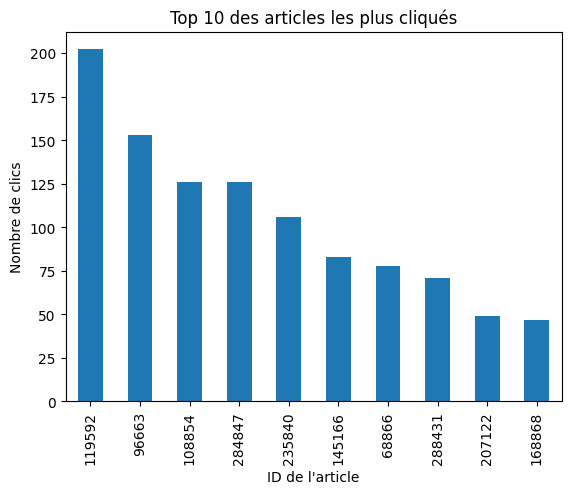

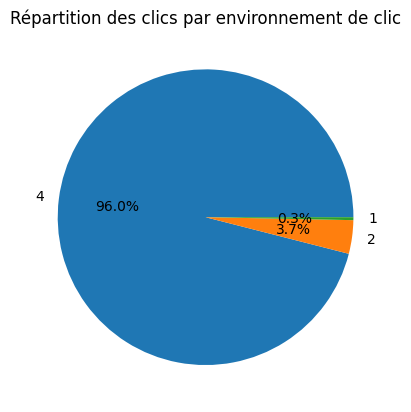

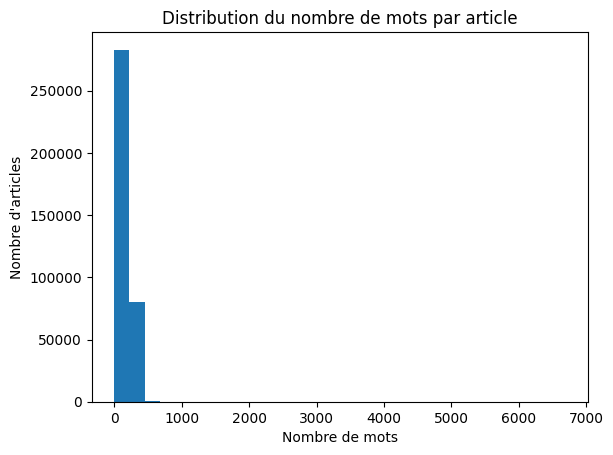

In [8]:
# Distribution des clics par article dans clicks_sample.csv
clicks_sample_df['click_article_id'].value_counts().head(10).plot(kind='bar')
plt.title('Top 10 des articles les plus cliqués')
plt.xlabel('ID de l\'article')
plt.ylabel('Nombre de clics')
plt.show()

# Répartition des clics par environnement de clic dans clicks_sample.csv
clicks_sample_df['click_environment'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Répartition des clics par environnement de clic')
plt.ylabel('')
plt.show()

# Distribution du nombre de mots par article dans articles_metadata.csv
articles_metadata_df['words_count'].plot(kind='hist', bins=30)
plt.title('Distribution du nombre de mots par article')
plt.xlabel('Nombre de mots')
plt.ylabel('Nombre d\'articles')
plt.show()


## Préparation des données
Nous allons maintenant prétraiter les données pour le modèle de recommandation.

In [9]:
# Analyse des données
analysis_results = {}
# Valeurs manquantes
analysis_results['clicks_sample_missing'] = clicks_sample_df.isnull().sum()
analysis_results['articles_metadata_missing'] = articles_metadata_df.isnull().sum()

# Doublons
analysis_results['clicks_sample_duplicates'] = clicks_sample_df.duplicated().sum()
analysis_results['articles_metadata_duplicates'] = articles_metadata_df.duplicated().sum()

analysis_results

{'clicks_sample_missing': user_id                0
 session_id             0
 session_start          0
 session_size           0
 click_article_id       0
 click_timestamp        0
 click_environment      0
 click_deviceGroup      0
 click_os               0
 click_country          0
 click_region           0
 click_referrer_type    0
 dtype: int64,
 'articles_metadata_missing': article_id       0
 category_id      0
 created_at_ts    0
 publisher_id     0
 words_count      0
 dtype: int64,
 'clicks_sample_duplicates': 0,
 'articles_metadata_duplicates': 0}

# Développement du Modèle de Recommandation
- Filtrage collaboratif article-article basé sur les clics.
- Calcul de la similarité cosinus entre les articles.

preapration des data

In [10]:
# Encodage des variables catégorielles
label_encoder_user = LabelEncoder()
label_encoder_article = LabelEncoder()

# Ajuster le LabelEncoder sur tous les articles présents dans les deux DataFrames
all_articles = pd.concat([clicks_sample_df['click_article_id'], articles_metadata_df['article_id']]).unique()
label_encoder_article.fit(all_articles)

clicks_sample_df['user_id'] = label_encoder_user.fit_transform(clicks_sample_df['user_id'])
clicks_sample_df['click_article_id'] = label_encoder_article.transform(clicks_sample_df['click_article_id'])
articles_metadata_df['article_id'] = label_encoder_article.transform(articles_metadata_df['article_id'])

# Normalisation ou standardisation si nécessaire (exemple ici non inclus)

# Features basées sur le texte
# Pour cet exemple, supposons que 'article_content' est une colonne contenant le contenu textuel des articles
# Si 'article_content' n'existe pas, utilisez une colonne textuelle appropriée
# articles_metadata_df['article_content'] = articles_metadata_df['title'] + " " + articles_metadata_df['description']

# Ajout d'une colonne fictive 'article_content' pour l'exemple
articles_metadata_df['article_content'] = articles_metadata_df['article_id'].astype(str)

tfidf_vectorizer = TfidfVectorizer(max_features=100)
tfidf_matrix = tfidf_vectorizer.fit_transform(articles_metadata_df['article_content'])

# Construction des matrices utilisateur-article
clicks_sample_df['interaction'] = 1  # Ajouter une colonne d'interaction binaire
user_article_matrix = clicks_sample_df.pivot(index='user_id', columns='click_article_id', values='interaction')
user_article_matrix.fillna(0, inplace=True)

# Sauvegarde des matrices pour une utilisation ultérieure
user_article_matrix.to_csv('user_article_matrix.csv')

# Aperçu des transformations
print("Aperçu de clicks_sample_df:")
print(clicks_sample_df.head(), "\n")
print("Aperçu de articles_metadata_df:")
print(articles_metadata_df.head(), "\n")
print("Aperçu de la matrice utilisateur-article:")
print(user_article_matrix.head(), "\n")

Aperçu de clicks_sample_df:
   user_id        session_id  session_start  session_size  click_article_id  \
0        0  1506825423271737  1506825423000             2            157541   
1        0  1506825423271737  1506825423000             2             68866   
2        1  1506825426267738  1506825426000             2            235840   
3        1  1506825426267738  1506825426000             2             96663   
4        2  1506825435299739  1506825435000             2            119592   

   click_timestamp  click_environment  click_deviceGroup  click_os  \
0    1506826828020                  4                  3        20   
1    1506826858020                  4                  3        20   
2    1506827017951                  4                  1        17   
3    1506827047951                  4                  1        17   
4    1506827090575                  4                  1        17   

   click_country  click_region  click_referrer_type  interaction  
0        

## Fonction de recommandation basée sur la similarité article-article

In [11]:
# Préparation des données pour les modèles de recommandation
try:
    # Filtrage collaboratif article-article basé sur les clics
    article_user_matrix = clicks_sample_df.pivot_table(index='user_id', columns='click_article_id', values='session_id', aggfunc='count').fillna(0)
    
    # Vérifions la matrice utilisateur-article
    print("Aperçu de la matrice utilisateur-article:")
    print(article_user_matrix.head())

    # Convertir la matrice utilisateur-article en tenseur TensorFlow
    article_user_matrix_tensor = tf.convert_to_tensor(article_user_matrix.values, dtype=tf.float32)

    # Normaliser la matrice utilisateur-article
    normalized_article_user_matrix = tf.nn.l2_normalize(article_user_matrix_tensor, axis=0)

    # Calcul de la similarité cosinus entre les articles en utilisant TensorFlow
    article_similarity = tf.matmul(tf.transpose(normalized_article_user_matrix), normalized_article_user_matrix).numpy()
    
    # Vérifions la matrice de similarité
    print("Aperçu de la matrice de similarité:")
    print(article_similarity[:5, :5])  # Affichage d'un aperçu pour éviter trop de données

    # Fonction de recommandation basée sur la similarité article-article
    def recommend_articles_article_based(article_id, num_recommendations=5):
        article_idx = article_user_matrix.columns.get_loc(article_id)
        similar_articles = list(enumerate(article_similarity[article_idx]))
        similar_articles = sorted(similar_articles, key=lambda x: x[1], reverse=True)
        recommended_articles = [article_user_matrix.columns[i[0]] for i in similar_articles[1:num_recommendations+1]]
        return recommended_articles

    # Exemple de recommandation d'articles pour un article donné
    article_id_example = article_user_matrix.columns[0]
    print(f"Recommandations pour l'article {article_id_example} : {recommend_articles_article_based(article_id_example)}")
    
except Exception as e:
    print(f"Une erreur s'est produite: {e}")


Aperçu de la matrice utilisateur-article:
click_article_id  2137    2662    4243    4658    7947    8844    10955   \
user_id                                                                    
0                    0.0     0.0     0.0     0.0     0.0     0.0     0.0   
1                    0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2                    0.0     0.0     0.0     0.0     0.0     0.0     0.0   
3                    0.0     0.0     0.0     0.0     0.0     0.0     0.0   
4                    0.0     0.0     0.0     0.0     0.0     0.0     0.0   

click_article_id  13337   13540   14197   ...  352774  352809  353669  355863  \
user_id                                   ...                                   
0                    0.0     0.0     0.0  ...     0.0     0.0     0.0     0.0   
1                    0.0     0.0     0.0  ...     0.0     0.0     0.0     0.0   
2                    0.0     0.0     0.0  ...     0.0     0.0     0.0     0.0   
3                   

## Recommandation basée sur les métadonnées des articles (TF-IDF et similarité cosinus)

In [12]:
# Ajouter des colonnes fictives 'title' et 'content' pour la démonstration
articles_metadata_df['title'] = ["Example Title"] * len(articles_metadata_df)
articles_metadata_df['content'] = ["Example Content"] * len(articles_metadata_df)

# Création de la matrice TF-IDF
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(articles_metadata_df['title'] + " " + articles_metadata_df['content'])

# Réduction de dimensions avec TruncatedSVD
n_components = min(100, tfidf_matrix.shape[1])
svd = TruncatedSVD(n_components=n_components)
reduced_tfidf_matrix = svd.fit_transform(tfidf_matrix)

# Création de l'index Annoy
annoy_index = AnnoyIndex(n_components, 'angular')
for i in range(reduced_tfidf_matrix.shape[0]):
    annoy_index.add_item(i, reduced_tfidf_matrix[i, :])
annoy_index.build(10)  # Construire l'index avec 10 arbres

# Sauvegarder l'index
annoy_index.save('annoy_index.ann')

# Fonction pour recommander des articles basés sur le contenu
def recommend_articles_content_based(article_id, num_recommendations=5):
    article_idx = articles_metadata_df[articles_metadata_df['article_id'] == article_id].index[0]
    similar_article_indices = annoy_index.get_nns_by_item(article_idx, num_recommendations+1)[1:]  # Ignorer l'article lui-même
    recommended_articles = articles_metadata_df['article_id'].iloc[similar_article_indices].tolist()
    return recommended_articles

# Exemple de recommandation d'articles basée sur le contenu pour un article donné
article_id_example = articles_metadata_df['article_id'].iloc[0]
print(f"Recommandations basées sur le contenu pour l'article {article_id_example} : {recommend_articles_content_based(article_id_example)}")


/Users/cyrilleguillaud/miniforge3/envs/tf_env/lib/python3.9/site-packages/sklearn/decomposition/_truncated_svd.py:268: RuntimeWarning: invalid value encountered in divide
  self.explained_variance_ratio_ = exp_var / full_var


Recommandations basées sur le contenu pour l'article 0 : [12115, 14765, 15459, 17505, 22305]


## Fonction de recommandation basée sur le contenu

In [13]:
# Vérifiez si TensorFlow utilise le GPU
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

# Chargement des données
articles_metadata_df = pd.read_csv('../data/articles_metadata.csv')

# Ajouter des colonnes fictives 'title' et 'content' pour la démonstration
articles_metadata_df['title'] = ["Example Title"] * len(articles_metadata_df)
articles_metadata_df['content'] = ["Example Content"] * len(articles_metadata_df)

# Création de la matrice TF-IDF
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(articles_metadata_df['title'] + " " + articles_metadata_df['content'])

# Réduction de dimensions avec TruncatedSVD
n_components = min(100, tfidf_matrix.shape[1])
svd = TruncatedSVD(n_components=n_components)
reduced_tfidf_matrix = svd.fit_transform(tfidf_matrix)

# Création de l'index Annoy
annoy_index = AnnoyIndex(n_components, 'angular')
for i in range(reduced_tfidf_matrix.shape[0]):
    annoy_index.add_item(i, reduced_tfidf_matrix[i, :])
annoy_index.build(10)  # Construire l'index avec 10 arbres

# Sauvegarder l'index (optionnel)
annoy_index.save('annoy_index.ann')

# Fonction pour recommander des articles basés sur le contenu
def recommend_articles_content_based(article_id, num_recommendations=5):
    article_idx = articles_metadata_df[articles_metadata_df['article_id'] == article_id].index[0]
    similar_article_indices = annoy_index.get_nns_by_item(article_idx, num_recommendations + 1)[1:]  # Ignorer l'article lui-même
    recommended_articles = articles_metadata_df['article_id'].iloc[similar_article_indices].tolist()
    return recommended_articles

# Exemple de recommandation d'articles basée sur le contenu pour un article donné
article_id_example = articles_metadata_df['article_id'].iloc[0]
print(f"Recommandations basées sur le contenu pour l'article {article_id_example} : {recommend_articles_content_based(article_id_example)}")


Num GPUs Available:  0


/Users/cyrilleguillaud/miniforge3/envs/tf_env/lib/python3.9/site-packages/sklearn/decomposition/_truncated_svd.py:268: RuntimeWarning: invalid value encountered in divide
  self.explained_variance_ratio_ = exp_var / full_var


Recommandations basées sur le contenu pour l'article 0 : [2662, 11226, 13161, 20870, 39468]


## Recommandation hybride combinant filtrage collaboratif et basé sur le contenu

In [14]:
# Vérifiez si TensorFlow utilise le GPU
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

# Chargement des données
articles_metadata_df = pd.read_csv('../data/articles_metadata.csv')
clicks_sample_df = pd.read_csv('../data/clicks_sample.csv')

# Préparation des données pour le filtrage collaboratif
article_user_matrix = clicks_sample_df.pivot_table(index='user_id', columns='click_article_id', values='session_id', aggfunc='count').fillna(0)

# Calcul de la similarité cosinus pour le filtrage collaboratif
article_similarity = cosine_similarity(article_user_matrix.T)

# Fonction de recommandation basée sur le filtrage collaboratif
def recommend_articles_article_based(article_id, num_recommendations=5):
    article_idx = article_user_matrix.columns.get_loc(article_id)
    similar_articles = list(enumerate(article_similarity[article_idx]))
    similar_articles = sorted(similar_articles, key=lambda x: x[1], reverse=True)
    recommended_articles = [article_user_matrix.columns[i[0]] for i in similar_articles[1:num_recommendations+1]]
    return recommended_articles

# Ajouter des colonnes fictives 'title' et 'content' pour la démonstration
articles_metadata_df['title'] = ["Example Title"] * len(articles_metadata_df)
articles_metadata_df['content'] = ["Example Content"] * len(articles_metadata_df)

# Création de la matrice TF-IDF
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(articles_metadata_df['title'] + " " + articles_metadata_df['content'])

# Réduction de dimensions avec TruncatedSVD
n_components = min(100, tfidf_matrix.shape[1])
svd = TruncatedSVD(n_components=n_components)
reduced_tfidf_matrix = svd.fit_transform(tfidf_matrix)

# Création de l'index Annoy
annoy_index = AnnoyIndex(n_components, 'angular')
for i in range(reduced_tfidf_matrix.shape[0]):
    annoy_index.add_item(i, reduced_tfidf_matrix[i, :])
annoy_index.build(10)  # Construire l'index avec 10 arbres

# Fonction pour recommander des articles basés sur le contenu
def recommend_articles_content_based(article_id, num_recommendations=5):
    article_idx = articles_metadata_df[articles_metadata_df['article_id'] == article_id].index[0]
    similar_article_indices = annoy_index.get_nns_by_item(article_idx, num_recommendations + 1)[1:]  # Ignorer l'article lui-même
    recommended_articles = articles_metadata_df['article_id'].iloc[similar_article_indices].tolist()
    return recommended_articles

# Recommandation hybride combinant filtrage collaboratif et basé sur le contenu
def hybrid_recommendation(user_id, num_recommendations=5):
    # Recommandations basées sur le filtrage collaboratif
    user_clicks = article_user_matrix.loc[user_id]
    user_clicks = user_clicks[user_clicks > 0]
    collaborative_recommendations = []
    for article_id in user_clicks.index:
        collaborative_recommendations.extend(recommend_articles_article_based(article_id, num_recommendations))
    collaborative_recommendations = list(set(collaborative_recommendations))
    
    # Recommandations basées sur le contenu
    content_based_recommendations = []
    for article_id in user_clicks.index:
        content_based_recommendations.extend(recommend_articles_content_based(article_id, num_recommendations))
    content_based_recommendations = list(set(content_based_recommendations))
    
    # Combiner les recommandations
    combined_recommendations = list(set(collaborative_recommendations + content_based_recommendations))
    return combined_recommendations[:num_recommendations]

# Exemple de recommandation hybride pour un utilisateur donné
user_id_example = article_user_matrix.index[0]
print(f"Recommandations hybrides pour l'utilisateur {user_id_example} : {hybrid_recommendation(user_id_example)}")


Num GPUs Available:  0


/Users/cyrilleguillaud/miniforge3/envs/tf_env/lib/python3.9/site-packages/sklearn/decomposition/_truncated_svd.py:268: RuntimeWarning: invalid value encountered in divide
  self.explained_variance_ratio_ = exp_var / full_var


Recommandations hybrides pour l'utilisateur 0 : [157541, 20870, 2662, 205897, 13161]


## Sauvegarde des données prétraitées

Nous allons sauvegarder les données prétraitées pour une utilisation ultérieure dans l'entraînement du modèle.

In [17]:
import joblib
# Importation des bibliothèques nécessaires
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from flask import Flask, request, jsonify
import joblib
import numpy as np
import pandas as pd

# Chemins relatifs pour sauvegarder les modèles et les données
article_user_matrix_path = 'models/article_user_matrix.pkl'
article_similarity_path = 'models/article_similarity.pkl'
tfidf_vectorizer_path = 'models/tfidf_vectorizer.pkl'
tfidf_matrix_path = 'models/tfidf_matrix.pkl'

# Créer le répertoire 'models' s'il n'existe pas
import os
if not os.path.exists('models'):
    os.makedirs('models')

# Enregistrer et suivre les modèles
joblib.dump(article_user_matrix, article_user_matrix_path)
joblib.dump(article_similarity, article_similarity_path)
joblib.dump(tfidf_vectorizer, tfidf_vectorizer_path)
joblib.dump(tfidf_matrix, tfidf_matrix_path)

print("Modèles et données préparées sauvegardés.")

Modèles et données préparées sauvegardés.


### Distribution des Interactions des Utilisateurs avec les Articles
Ce graphique montre la fréquence à laquelle les utilisateurs interagissent avec différents articles. En observant la distribution, nous pouvons identifier si certains articles reçoivent beaucoup plus d'interactions que d'autres, ce qui peut indiquer des articles particulièrement populaires ou des biais dans les données.

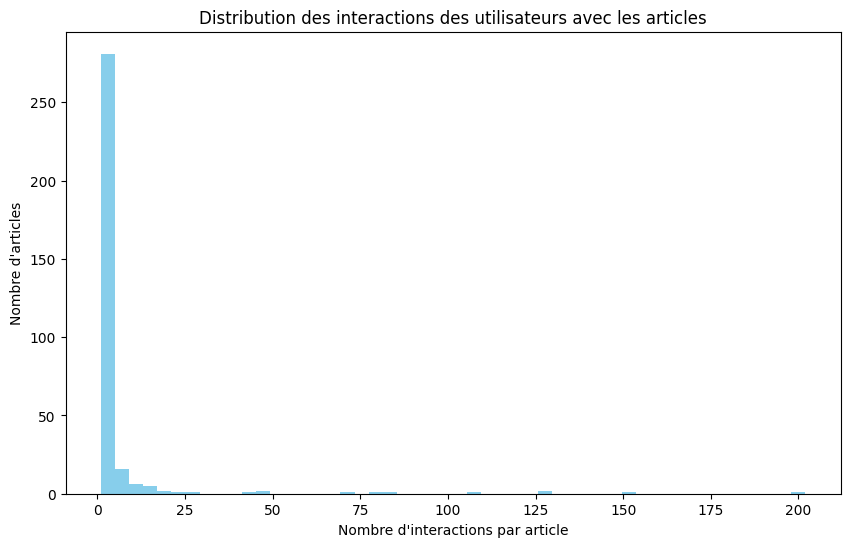

In [18]:
# Distribution des interactions des utilisateurs avec les articles
interaction_counts = clicks_sample_df['click_article_id'].value_counts()

plt.figure(figsize=(10, 6))
plt.hist(interaction_counts, bins=50, color='skyblue')
plt.xlabel('Nombre d\'interactions par article')
plt.ylabel('Nombre d\'articles')
plt.title('Distribution des interactions des utilisateurs avec les articles')
plt.show()

### Histogramme de la Similarité Cosinus des Articles
Cet histogramme montre la distribution des similarités cosinus entre les articles. Cela nous permet de voir si la plupart des articles ont des similarités élevées ou faibles les uns avec les autres. Une distribution concentrée autour de 1 indiquerait que de nombreux articles sont très similaires, tandis qu'une distribution plus uniforme pourrait indiquer une plus grande diversité parmi les articles.

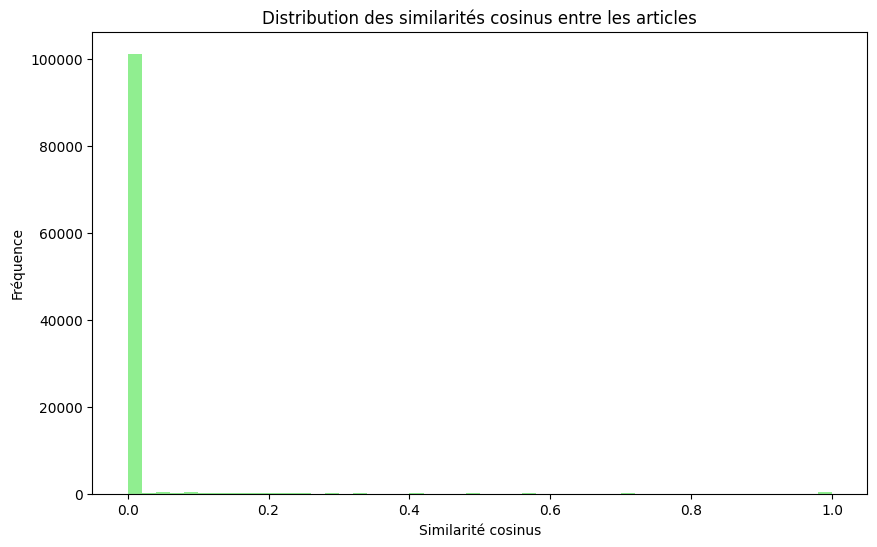

In [19]:
# 'article_similarity` est la matrice de similarité cosinus des articles pour le filtrage collaboratif
similarities = article_similarity.flatten()

plt.figure(figsize=(10, 6))
plt.hist(similarities, bins=50, color='lightgreen')
plt.xlabel('Similarité cosinus')
plt.ylabel('Fréquence')
plt.title('Distribution des similarités cosinus entre les articles')
plt.show()


### Diagramme en Barres des Recommandations pour un Utilisateur Spécifique
Ce diagramme en barres montre les articles recommandés pour un utilisateur spécifique en fonction de trois méthodes : le filtrage collaboratif, le filtrage basé sur le contenu et l'approche hybride. Cela permet de comparer les différents types de recommandations et d'observer les similitudes ou différences entre elles. En visualisant les recommandations, nous pouvons mieux comprendre l'impact de chaque méthode et comment elles se complètent dans l'approche hybride.

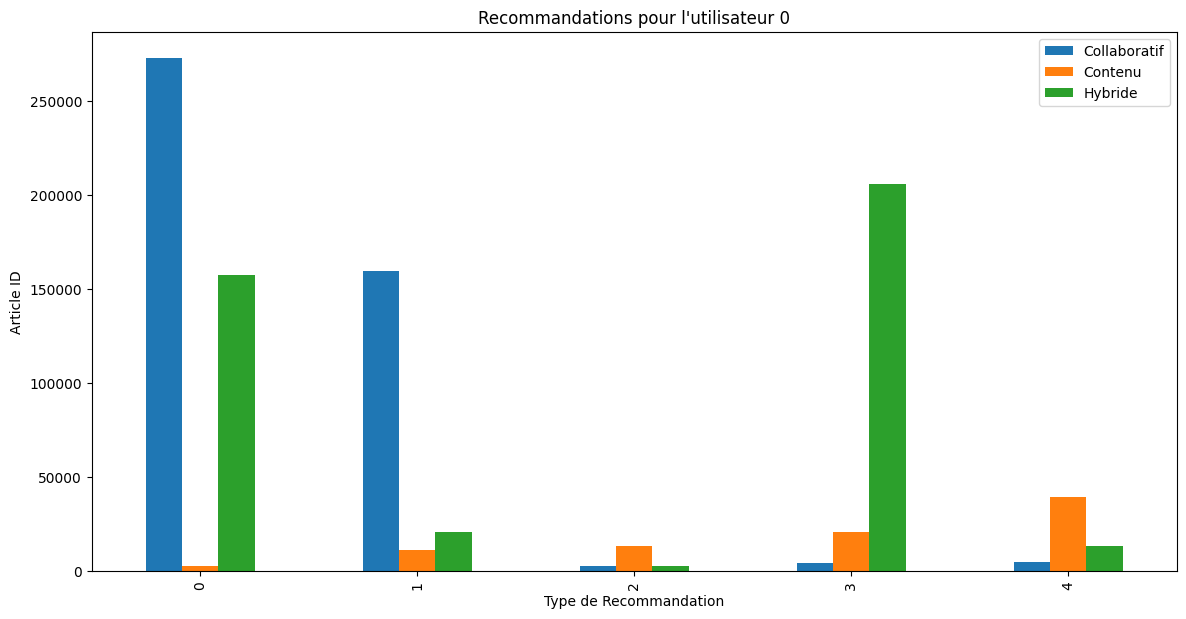

In [20]:
# user_id_example est l'identifiant de l'utilisateur pour lequel nous voulons afficher les recommandations
collaborative_recommendations = recommend_articles_article_based(article_user_matrix.columns[0], num_recommendations=5)
content_recommendations = recommend_articles_content_based(articles_metadata_df['article_id'].iloc[0], num_recommendations=5)
hybrid_recommendations = hybrid_recommendation(user_id_example, num_recommendations=5)

# Créer un DataFrame pour les recommandations
recommendations_df = pd.DataFrame({
    'Collaboratif': collaborative_recommendations,
    'Contenu': content_recommendations,
    'Hybride': hybrid_recommendations
})

recommendations_df.plot(kind='bar', figsize=(14, 7))
plt.xlabel('Type de Recommandation')
plt.ylabel('Article ID')
plt.title(f'Recommandations pour l\'utilisateur {user_id_example}')
plt.show()


### Visualisation des Matrices de Similarité
Cette heatmap montre les similarités cosinus entre les 10 premiers articles de la matrice de similarité. Chaque cellule représente la similarité entre deux articles, avec des couleurs plus claires indiquant des similarités plus élevées. En visualisant une partie de la matrice de similarité, nous pouvons obtenir une idée de la structure des similarités dans nos données, identifier des groupes d'articles similaires et évaluer visuellement l'efficacité de notre modèle de similarité.

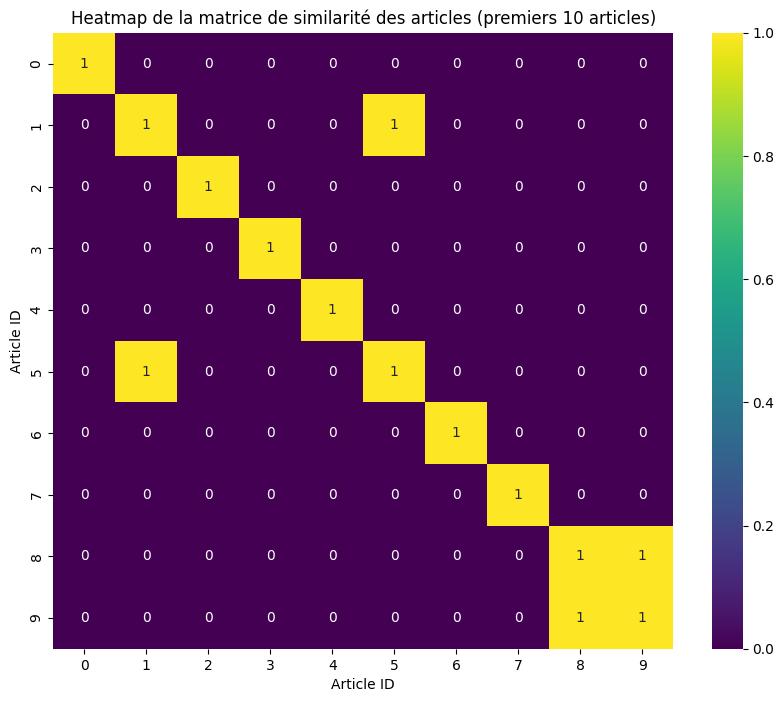

In [21]:
# Visualisation de la matrice de similarité pour les articles
plt.figure(figsize=(10, 8))
sns.heatmap(article_similarity[:10, :10], cmap='viridis', annot=True)
plt.title('Heatmap de la matrice de similarité des articles (premiers 10 articles)')
plt.xlabel('Article ID')
plt.ylabel('Article ID')
plt.show()

## Déploiement Serverless avec Azure Functions
Api local de test

In [2]:
from flask import Flask, request, jsonify
import joblib
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

app = Flask(__name__)

# Chemins relatifs des fichiers sauvegardés
article_user_matrix_path = 'models/article_user_matrix.pkl'
article_similarity_path = 'models/article_similarity.pkl'
tfidf_vectorizer_path = 'models/tfidf_vectorizer.pkl'
tfidf_matrix_path = 'models/tfidf_matrix.pkl'
articles_metadata_path = '../data/articles_metadata.csv'

# Charger les fichiers sauvegardés
article_user_matrix = joblib.load(article_user_matrix_path)
article_similarity = joblib.load(article_similarity_path)
tfidf_vectorizer = joblib.load(tfidf_vectorizer_path)
tfidf_matrix = joblib.load(tfidf_matrix_path)

# Charger les métadonnées des articles
articles_metadata_df = pd.read_csv(articles_metadata_path)

# Fonction de recommandation collaborative
def collaborative_recommendation(user_id, num_recommendations=5):
    if user_id in article_user_matrix.index:
        user_clicks = article_user_matrix.loc[user_id]
        user_clicks = user_clicks[user_clicks > 0]
        collaborative_recommendations = []
        for article_id in user_clicks.index:
            similar_articles = np.argsort(article_similarity[article_id])[::-1]
            collaborative_recommendations.extend(similar_articles[:num_recommendations])
        collaborative_recommendations = list(set(collaborative_recommendations))
        return collaborative_recommendations[:num_recommendations]
    else:
        return []

# Fonction de recommandation basée sur le contenu
def content_based_recommendation(article_id, num_recommendations=5):
    if article_id in articles_metadata_df['article_id'].values:
        article_idx = articles_metadata_df[articles_metadata_df['article_id'] == article_id].index[0]
        article_vector = tfidf_matrix[article_idx]
        similarities = cosine_similarity(article_vector, tfidf_matrix).flatten()
        similar_articles = np.argsort(-similarities)[1:num_recommendations+1]
        recommended_articles = articles_metadata_df['article_id'].iloc[similar_articles].tolist()
        return recommended_articles
    else:
        return []

# Fonction de recommandation hybride
def hybrid_recommendation(user_id, num_recommendations=5):
    collaborative_recommendations = collaborative_recommendation(user_id, num_recommendations)
    user_clicks = article_user_matrix.loc[user_id]
    user_clicks = user_clicks[user_clicks > 0]
    content_based_recommendations = []
    for article_id in user_clicks.index:
        content_based_recommendations.extend(content_based_recommendation(article_id, num_recommendations))
    content_based_recommendations = list(set(content_based_recommendations))
    combined_recommendations = list(set(collaborative_recommendations + content_based_recommendations))
    return combined_recommendations[:num_recommendations]

@app.route('/recommend/collaborative', methods=['GET'])
def recommend_collaborative():
    user_id = int(request.args.get('user_id'))
    recommendations = collaborative_recommendation(user_id)
    return jsonify(recommendations)

@app.route('/recommend/content', methods=['GET'])
def recommend_content():
    article_id = int(request.args.get('article_id'))
    recommendations = content_based_recommendation(article_id)
    return jsonify(recommendations)

@app.route('/recommend/hybrid', methods=['GET'])
def recommend_hybrid():
    user_id = int(request.args.get('user_id'))
    recommendations = hybrid_recommendation(user_id)
    return jsonify(recommendations)

if __name__ == '__main__':
    app.run(debug=True, port=5005)  # Utilisation du port 5051 pour éviter les conflits


 * Serving Flask app '__main__'
 * Debug mode: on


 * Running on http://127.0.0.1:5005
Press CTRL+C to quit
 * Restarting with watchdog (fsevents)
Traceback (most recent call last):
  File "/Users/cyrilleguillaud/miniforge3/envs/tf_env/lib/python3.9/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/Users/cyrilleguillaud/miniforge3/envs/tf_env/lib/python3.9/site-packages/traitlets/config/application.py", line 1074, in launch_instance
    app.initialize(argv)
  File "/Users/cyrilleguillaud/miniforge3/envs/tf_env/lib/python3.9/site-packages/traitlets/config/application.py", line 118, in inner
    return method(app, *args, **kwargs)
  File "/Users/cyrilleguillaud/miniforge3/envs/tf_env/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 692, in initialize
    self.init_sockets()
  File "/Users/cyrilleguillaud/miniforge3/envs/tf_env/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 331, in init_sockets
    self.shell_port = self._bind_socket(self.shell_socket, self.shell_port)
  

SystemExit: 1

/Users/cyrilleguillaud/miniforge3/envs/tf_env/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3558: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [3]:
%tb

SystemExit: 1

## Web app


In [ ]:
# web_app.py
from flask import Flask, render_template, request
import requests

app = Flask(__name__, template_folder='templates')

# URL de l'API
API_URL = "http://127.0.0.1:5000"

@app.route('/')
def home():
    return render_template('index.html')

@app.route('/recommend', methods=['POST'])
def recommend():
    user_id = request.form.get('user_id')
    article_id = request.form.get('article_id')
    rec_type = request.form.get('rec_type')

    if rec_type == 'collaborative':
        response = requests.get(f"{API_URL}/recommend/collaborative", params={'user_id': user_id})
    elif rec_type == 'content':
        response = requests.get(f"{API_URL}/recommend/content", params={'article_id': article_id})
    else:  # rec_type == 'hybrid'
        response = requests.get(f"{API_URL}/recommend/hybrid", params={'user_id': user_id})

    recommendations = response.json()

    return render_template('index.html', recommendations=recommendations)

if __name__ == '__main__':
    app.run(debug=True, port=5001)